In [314]:
from salad.serialize import read
from pathlib import Path
from functools import lru_cache
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import astropy.table
import astropy.units as u

In [154]:
def load_results(search_prefix, detector, snr, time_type, search_label, step="filtered"):
    # get recoveries at a certain step
    p = Path(f"/epyc/projects/salad/search/{search_prefix}/DEEP/20190403/A0c/detector_{detector}/snr_{snr}/{time_type}/{search_label}")
    return read(list(p.rglob(f"{step}.pkl"))[0])


def recoveries(search_prefix, detector, snr, time_type, search_label, step="filtered"):
    # get recoveries at a certain step
    p = Path(f"/epyc/projects/salad/search/{search_prefix}/DEEP/20190403/A0c/detector_{detector}/snr_{snr}/{time_type}/{search_label}")
    return read(list(p.rglob(f"{step}_recovery.pkl"))[0])

def was_found(fake_recovery, threshold=15, vmin=0.1, vmax=0.5):
    ret = []
    for o in fake_recovery:
        f = fake_recovery[o]
        found_points = False
        found_line = False
        n_points = 0
        n_lines = 0
        for c in f['points']:
            p = f['points'][c]
            precision = p['fake']/p['total']
            recall = p['fake']/f['catalog']['fake']
            if precision > 0.5:
                found_points = True
                n_points += 1
                
            if c in f['line']:
                l = f['line'][c]
                line_recovery = l['fake']/l['total']
                if precision > 0.5 and line_recovery > 0.5:
                    found_line = True
                    n_lines += 1
        
        v = ((f['info']['vra']**2 + f['info']['vdec']**2)**0.5)
        if hasattr(v, "unit"):
            v = v.value
        ret.append(
            {
                "orbit": o,
                "found_points": found_points,
                "found_line": found_line,
                "points": f['catalog']['fake'],
                "n_points": n_points,
                "n_lines": n_lines,
                "fake_detection": f['catalog']['fake'],
                "fake_injection": f['catalog']['total'],
                "filtered": (v < vmin) | (v > vmax)
            }
        )
        
        if 'findable' in f['info']:
            ret[-1]['in_search'] = f['info']['findable']
        elif f['catalog']['total'] == 1:
            ret[-1]['in_search'] = False
            
            
    return astropy.table.Table(ret)

def bin_detection(catalog, min_mag, max_mag, dm=0.5, min_visits=10, mag_col='mag', found_col='found'):
    fraction_recovered = []
    i = 0
    m = min_mag
    mag = []
    lower = min_mag
    errors = []
    while lower < max_mag:
        lower = min_mag + i * dm
        upper = min_mag + (i + 1) * dm
        a = catalog[(catalog[mag_col] >= lower) & (catalog[mag_col] < upper)]
        if len(a) > 0:
            num_recovered = a[found_col].sum()
            num_possible = len(a)#a['catalog_possible'].sum()
            
            fraction_recovered.append(num_recovered/num_possible)
            mag.append((upper + lower) / 2)
            # num_recovered / num_total
            # sqrt(dx^2 + dy^2)
            errors.append((num_recovered**0.5)/num_possible)
#             errors.append((num_recovered + num_possible)**-0.5) # sqrt(dr**2 + da**2) where dr=sqrt(r)

        i += 1

    return mag, fraction_recovered, errors

from scipy.optimize import minimize, curve_fit
import numpy as np
from autograd import elementwise_grad as egrad
from autograd import jacobian, hessian
import autograd.numpy as autograd_np

def p(m, c, k, m_50):
    return c / (1 + autograd_np.exp(k * (m - m_50)))

def log_p(m, c, k, m_50):
    return autograd_np.log(c) - autograd_np.log(1 + autograd_np.exp(k * (m - m_50)))

def p_3(m, c, k1, k2, m_25):
    return p(m, c, k1, m_25) * p(m, 1, k2, m_25)

def log_p_3(m, c, k1, k2, m_25):
    return log_p(m, c, k1, m_25) + log_p(m, 1, k2, m_25)

def log_l(c, k, m_50, recovered_mag, missed_mag):
    if c > 1 or c < 0:
        return -autograd_np.inf
    return autograd_np.sum(log_p(recovered_mag, c, k, m_50)) + autograd_np.sum(autograd_np.log(1 - p(missed_mag, c, k, m_50)))


def log_l_3(c, k1, k2, m_25, recovered_mag, missed_mag):
    if c > 1 or c < 0:
        return -autograd_np.inf
    return (
        autograd_np.sum(autograd_np.log(p_3(recovered_mag, c, k1, k2, m_25))) + 
        autograd_np.sum(autograd_np.log(1 - p_3(missed_mag, c, k1, k2, m_25)))
    )

def fit_completeness(recovered_mag, missed_mag, eq=1, **kwargs):
    minimize_kwargs = dict(
        method="Nelder-Mead", 
        options=dict(maxiter=int(1e3))        
    )
    minimize_kwargs.update(kwargs)
    if eq == 1:
        log_likelihood = log_l
        init_x = autograd_np.array(minimize_kwargs.pop("init_x", [0.8, 1, 24]))
    else:
        log_likelihood = log_l_3
        init_x = autograd_np.array(minimize_kwargs.pop("init_x", [0.8, 1, 1, 24]))
    
    f = lambda x : -log_likelihood(*x, recovered_mag, missed_mag)
    df = egrad(f)
    jac = jacobian(f)
    hess = hessian(f)
    
    if minimize_kwargs['method'] != "Nelder-Mead":
        minimize_kwargs['jac'] = jac
        minimize_kwargs['hess'] = hess
    opt_result = minimize(f, init_x, **minimize_kwargs)
        
    return opt_result, hess(opt_result.x)


def do_fit(results, mag_col='mag', found_col='found'):
    recovered_mag = results[results[found_col]][mag_col].value
    missed_mag = results[~results[found_col]][mag_col].value

    opt_result, hess = fit_completeness(recovered_mag, missed_mag, eq=1)

    d = None
    if opt_result.success:
        best_fit = opt_result.x
        if hess is not None:
            fit_std = autograd_np.sqrt(autograd_np.diag(autograd_np.linalg.inv(hess)))
        else:
            fit_std = autograd_np.array([autograd_np.nan, autograd_np.nan, autograd_np.nan])
        d = {
            "c": best_fit[0],
            "k": best_fit[1],
            "m_50": best_fit[2],
            "sigma_c": fit_std[0],
            "sigma_k": fit_std[1],
            "sigma_m_50": fit_std[2],
        }

    return d


In [318]:
was_found(recoveries(search_prefix, 4, 3.0, "regular", "asteroid"))

orbit,found_points,found_line,points,n_points,n_lines,fake_detection,fake_injection,filtered,in_search
int64,bool,bool,int64,int64,int64,int64,int64,bool,bool
10172675,False,False,12,0,0,12,104,False,False
10616324,True,True,59,1,1,59,104,False,False
11292165,False,False,2,0,0,2,104,False,True
2074002,False,False,2,0,0,2,104,True,False
3057437,False,False,0,0,0,0,104,True,False
5013791,False,False,4,0,0,4,104,True,False
2099,False,False,2,0,0,2,104,True,False
4777780,False,False,0,0,0,0,102,True,False
14699459,True,True,84,1,1,84,104,False,True


In [319]:
t = astropy.table.join(was_found(recoveries(search_prefix, 4, 3.0, "regular", "asteroid")), mags)
t

orbit,found_points,found_line,points,n_points,n_lines,fake_detection,fake_injection,filtered,in_search,mag
int64,bool,bool,int64,int64,int64,int64,int64,bool,bool,float64
2099,False,False,2,0,0,2,104,True,False,26.600090279060534
188646,False,False,60,0,0,60,104,True,False,24.12278263090937
1908949,False,False,52,0,0,52,104,True,False,24.087621527658047
2074002,False,False,2,0,0,2,104,True,False,26.29548856544037
2263754,False,False,10,0,0,10,104,True,False,24.794194560136866
2763369,False,False,0,0,0,0,104,True,False,25.36786044286261
3057437,False,False,0,0,0,0,104,True,False,24.878727934345882
4777780,False,False,0,0,0,0,102,True,False,21.895424154188383
5013791,False,False,4,0,0,4,104,True,False,24.906896792682247


In [108]:
t[t['in_search'] & (t['fake_injection'] > 15)]

orbit,found_points,found_line,points,n_points,n_lines,fake_detection,fake_injection,in_search,mag
int64,bool,bool,int64,int64,int64,int64,int64,bool,float64
10200295,False,False,3,0,0,3,104,True,26.451403003065966
11292165,False,False,2,0,0,2,104,True,25.552268936090183
11926129,True,True,32,1,1,32,104,True,24.755975132108603
14699459,True,True,84,1,1,84,104,True,20.228985944638985
14969959,True,True,101,1,1,101,104,True,20.07949697719932


In [139]:
astropy.table.Table(g)

orbit,found_points,found_line,points,n_points,n_lines,fake_detection,fake_injection,in_search,detector
int64,bool,bool,int64,int64,int64,int64,int64,bool,int64
2099,False,False,2,0,0,2,104,False,4


In [157]:
import numpy as np

snrs = [3.0, 3.5, 4.0, 4.5, 5.0]
detectors = [i for i in range(1, 63) if i not in [2, 61]]
# detectors = [1, 3, 4]
fit_data = {}
fit_params = {}
# m_50 = []
# sigma_m_50 = []
# max_mags = []
for snr in snrs:
    fo = []
    for detector in detectors:
        try:
            r = recoveries("new", detector, snr, "regular", "asteroid")
        except:
            print(snr, detector)
        found = was_found(r)
        found['detector'] = detector
        fo.append(found)

    found = astropy.table.vstack(fo)
    fo = []
    for g in found.group_by("orbit"):
        g = astropy.table.Table(g)
        if len(g) > 1:
            idx = np.argmax(g[''])
            g['found_points'] = np.logical_or.reduce(g['found_points'])
            g['found_line'] = np.logical_or.reduce(g['found_line'])
            g['in_search'] = np.logical_or.reduce(g['in_search'])
            fo.append(astropy.table.Table(g[0]))
        else:
            fo.append(g)

    found = astropy.table.vstack(fo)
    

    # how do I distinguish t['points'] = 0 meaning not detected vs not included because of masks?

    t = astropy.table.join(found, mags, keys=['orbit'])
    # # t[t['fake_injection'] == 1]
    _t = t[t['in_search'] & (~t['filtered']) & (t['fake_injection'] > 15)]
#     plt.scatter(_t['mag'], _t['found_points'])
#     plt.show()

    fit_result = do_fit(_t, found_col='found_points')
    if fit_result:
        fit_data[snr] = _t
        fit_params[snr] = fit_result

#     plt.scatter(_t['mag'], _t['points'], c=_t['found_points'])
#     plt.axhline(15)
#     plt.show()

#     x = np.linspace(_t['mag'].min(), _t['mag'].max(), 100)
#     y = p(x, fit_result['c'], fit_result['k'], fit_result['m_50'])
#     plt.scatter(_t['mag'], _t['found_points'])
#     plt.plot(x, y)
#     plt.show()
    
    
#     m_50.append(fit_result['m_50'])
#     sigma_m_50.append(fit_result['sigma_m_50'])
#     max_mags.append(_t[_t['found_points']]['mag'].max())

/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)


In [180]:
wilson_score_interval(1, 1, 0)

(0.5, 1.0)

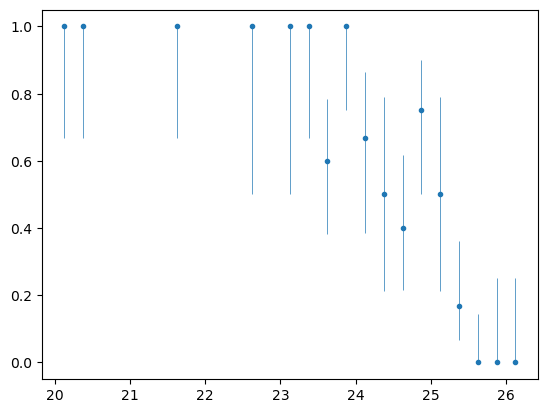

In [194]:
def wilson_score_interval(z_alpha, n_s, n_f):
    n = n_s + n_f
    m = (n_s + 0.5 * z_alpha**2) / (n + z_alpha**2)
    u = ((z_alpha) / (n + z_alpha**2)) *  ((n_s*n_f/n) + (z_alpha**2)/4)**0.5
    return m - u, m + u

def bin_detection(catalog, min_mag, max_mag, dm=0.5, min_visits=10, mag_col='mag', found_col='found'):
    fraction_recovered = []
    i = 0
    m = min_mag
    mag = []
    lower = min_mag
    errors = []
    while lower < max_mag:
        lower = min_mag + i * dm
        upper = min_mag + (i + 1) * dm
        a = catalog[(catalog[mag_col] >= lower) & (catalog[mag_col] < upper)]
        if len(a) > 0:
            num_recovered = a[found_col].sum()
            num_possible = len(a)#a['catalog_possible'].sum()
            
            fraction_recovered.append(num_recovered/num_possible)
            mag.append((upper + lower) / 2)
            # num_recovered / num_total
            # sqrt(dx^2 + dy^2)
            l, u = wilson_score_interval(1, num_recovered, num_possible - num_recovered)
            errors.append([num_recovered/num_possible - l, u - num_recovered/num_possible])
#             errors.append((num_recovered + num_possible)**-0.5) # sqrt(dr**2 + da**2) where dr=sqrt(r)

        i += 1

    return mag, fraction_recovered, np.array(errors).T


_x, _y, _yerr = bin_detection(fit_data[3.0], 18, 26, dm=0.25, found_col='found_points')
plt.errorbar(_x, _y, yerr=_yerr, fmt='o', lw=0.5, ms=3, c=f"C0")
plt.show()

In [343]:
_t

orbit,found_points,found_line,points,n_points,n_lines,fake_detection,fake_injection,filtered,in_search,detector,mag
int64,bool,bool,int64,int64,int64,int64,int64,bool,bool,int64,float64
5854665,True,True,95,1,1,95,104,False,True,39,23.582836462986492
10002376,True,False,89,1,0,89,104,False,True,59,24.054322260817777
10049768,True,True,24,1,1,24,99,False,True,28,24.739678663254164
10053463,False,False,3,0,0,3,104,False,True,1,25.510073572384727
10060709,False,False,0,0,0,0,25,False,True,16,25.71588619670486
10065221,True,True,104,1,1,104,104,False,True,36,23.188854359615995
10078694,False,False,4,0,0,4,104,False,True,60,25.270020906359747
10113319,True,True,100,1,1,100,104,False,True,47,23.584115512450673
10114448,False,False,7,0,0,7,104,False,True,26,25.68945954237534


In [397]:
x = np.linspace(18, 26, 100)

plt.figure(dpi=150)
for i, snr in enumerate([3.0, 4.0, 5.0]):
    f = fit_params[snr]
    y = p(x, f['c'], f['k'], f['m_50'])
    plt.plot(x, y, label=f'SNR>={snr}', color=f'C{i}')
    _x, _y, _yerr = bin_detection(fit_data[snr], 18, 26, found_col='found_points')
    plt.errorbar(_x, _y, yerr=_yerr, fmt='o', lw=0.5, ms=3, c=f"C{i}")
#     plt.scatter(_x, _y, c=f"C{i}")
    plt.ylim(-0.2, 1.2)
    plt.legend()
    plt.show()
    break

KeyError: 3.0

<Figure size 960x720 with 0 Axes>

KeyError: 'found_points'

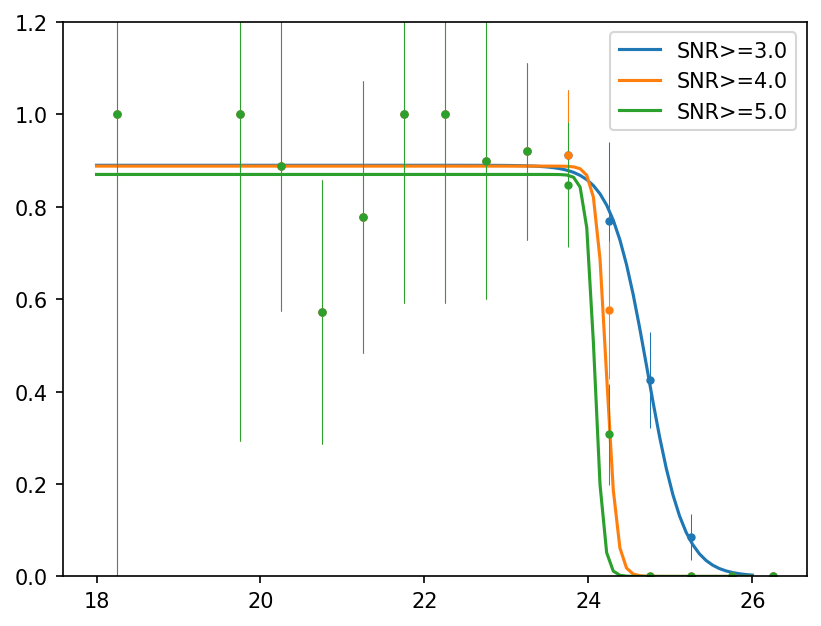

In [334]:
x = np.linspace(18, 26, 100)

plt.figure(dpi=150)
for i, snr in enumerate([3.0, 4.0, 5.0]):
    f = fit_params[snr]
    y = p(x, f['c'], f['k'], f['m_50'])
    plt.plot(x, y, label=f'SNR>={snr}', color=f'C{i}')
    _x, _y, _yerr = bin_detection(fit_data[snr], 18, 26, found_col='found_points')
    plt.errorbar(_x, _y, yerr=_yerr, fmt='o', lw=0.5, ms=3, c=f"C{i}")
#     plt.scatter(_x, _y, c=f"C{i}")
plt.ylim(0, 1.2)
plt.legend()
plt.show()

# stamps of fakes, perhaps trim edge?

In [249]:
max_mags

[25.296952346188572,
 24.755975132108603,
 24.298243964197773,
 24.298243964197773,
 24.177034647425465]

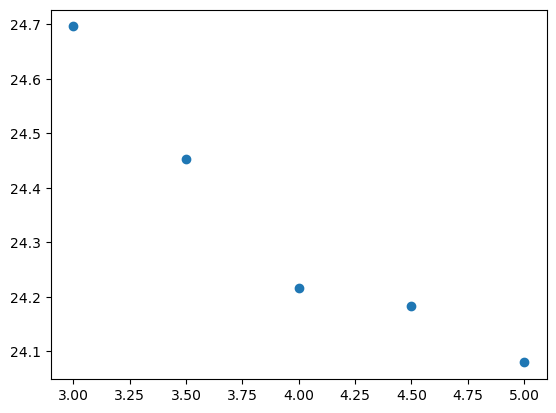

In [251]:
plt.scatter(snrs, m_50)
plt.show()

In [255]:
np.log10(1)

0.0

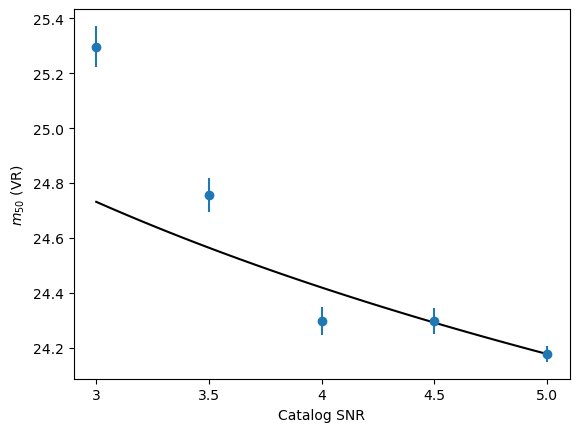

In [266]:
x = np.linspace(min(snrs), max(snrs), 100)
y = -(5/2) * np.log10(x / max(snrs)) + max_mags[snrs.index(5.0)]
plt.plot(x, y, color='k', label="expected")
plt.errorbar(snrs, max_mags, yerr=sigma_m_50, fmt='o')
plt.xticks(snrs, ["3", "3.5", "4", "4.5", "5.0"])
plt.xlabel("Catalog SNR")
plt.ylabel("$m_{50}$ (VR)")
plt.show()

In [269]:
k

orbit,found,points,findable
int64,bool,int64,bool
13039521,False,1,True


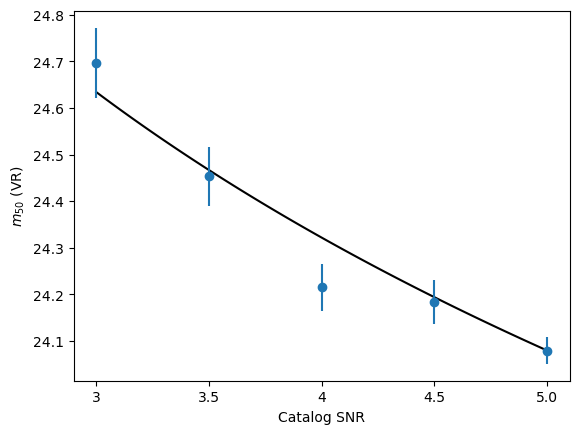

In [263]:
x = np.linspace(min(snrs), max(snrs), 100)
y = -(5/2) * np.log10(x / max(snrs)) + m_50[snrs.index(5.0)]
plt.plot(x, y, color='k', label="expected")
plt.errorbar(snrs, m_50, yerr=sigma_m_50, fmt='o')
plt.xticks(snrs, ["3", "3.5", "4", "4.5", "5.0"])
plt.xlabel("Catalog SNR")
plt.ylabel("$m_{50}$ (VR)")
plt.show()

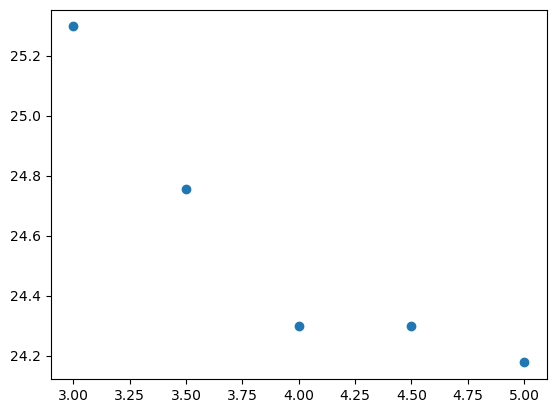

In [250]:
plt.scatter(snrs, max_mags)
plt.show()

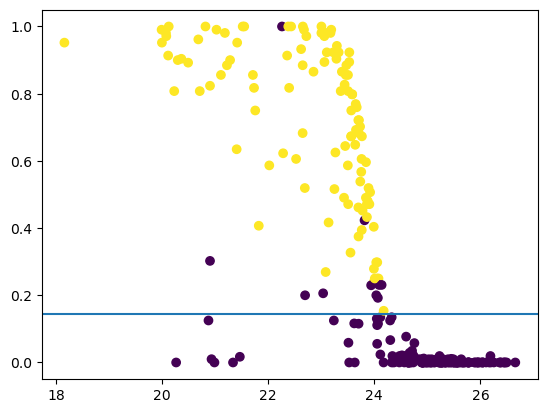

In [297]:
plt.scatter(_t['mag'], _t['fake_detection'] / _t['fake_injection'], c=_t['found_points'])
plt.axhline(15/104)
plt.show()

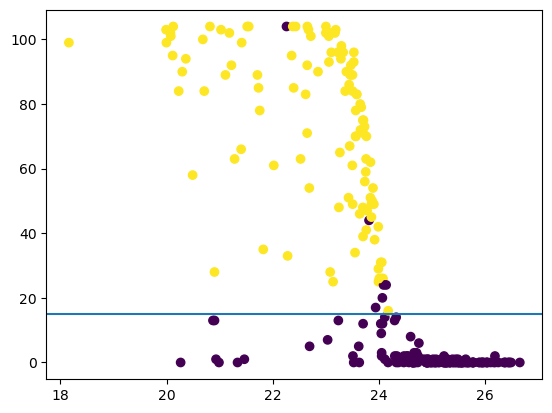

In [298]:
plt.scatter(_t['mag'], _t['fake_detection'], c=_t['found_points'])
plt.axhline(15)
plt.show()

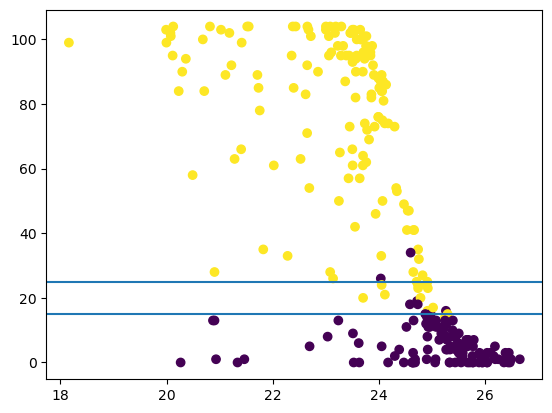

In [361]:
_t = fit_data[3.0]
plt.scatter(_t['mag'], _t['fake_detection'], c=_t['found_points'] & (~_t['filtered']))
plt.axhline(15)
plt.axhline(25)
plt.show()


orbit,found_points,found_line,points,n_points,n_lines,fake_detection,fake_injection,filtered,in_search,detector,mag
int64,bool,bool,int64,int64,int64,int64,int64,bool,bool,int64,float64
10155244,False,False,0,0,0,0,104,False,True,31,20.265076986255252
10580828,False,False,5,0,0,5,25,False,True,21,22.695686257748125
10976743,False,False,1,0,0,1,59,False,True,41,21.465905811344204
11394078,False,False,8,0,0,8,34,False,True,16,23.035964826160424
11414012,False,False,6,0,0,6,43,False,True,9,23.622005927008008
11565792,False,False,13,0,0,13,43,False,True,33,20.903537576603746
11943283,False,False,0,0,0,0,52,False,True,24,23.52727354976112
12342968,False,False,9,0,0,9,34,False,True,49,23.513127365337056
12420871,False,False,13,0,0,13,104,False,True,42,20.874750422830864


In [153]:
_x, _y, _yerr = bin_detection(fit_data[snr], 18, 26, found_col='found_points')

TypeError: bin_detection() got an unexpected keyword argument 'found_col'

In [ ]:
# I need to somehow exclude points that that didn't appear in the catalog...

In [ ]:
plt.scatter(_t['mag'], _t[''])

In [152]:
import numpy as np

snrs = [3.0, 3.5, 4.0, 4.5, 5.0]
detectors = [i for i in range(1, 63) if i not in [2, 61]]
# detectors = [1, 3, 4]
fit_data = {}
fit_params = {}
# m_50 = []
# sigma_m_50 = []
# max_mags = []
for snr in snrs:
    fo = []
    for detector in detectors:
        try:
            r = recoveries("new", detector, snr, "regular", "asteroid")
        except:
            print(snr, detector)
        found = was_found(r)
        found['detector'] = detector
        fo.append(found)

    found = astropy.table.vstack(fo)
    fo = []
    for g in found.group_by("orbit"):
        g = astropy.table.Table(g)
        if len(g) > 1:
            idx = np.argmax(g[''])
            g['found_points'] = np.logical_or.reduce(g['found_points'])
            g['found_line'] = np.logical_or.reduce(g['found_line'])
            g['in_search'] = np.logical_or.reduce(g['in_search'])
            fo.append(astropy.table.Table(g[0]))
        else:
            fo.append(g)

    found = astropy.table.vstack(fo)
    

    # how do I distinguish t['points'] = 0 meaning not detected vs not included because of masks?

    t = astropy.table.join(found, mags, keys=['orbit'])
#     _t = t[t['in_search'] & (~t['filtered']) & (t['fake_injection'] > 15)]
    fit_data[snr] = t
#     fit_result = do_fit(_t, found_col='found_points')
#     if fit_result:
#         fit_data[snr] = _t
#         fit_params[snr] = fit_result



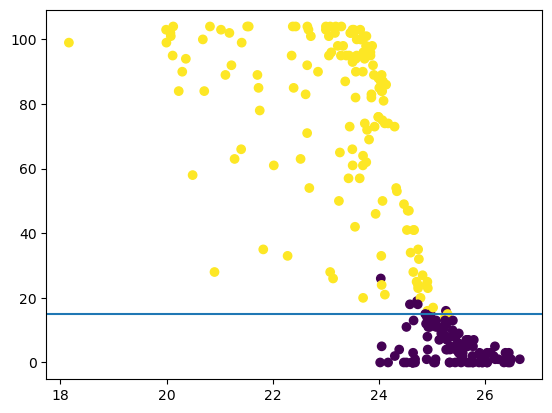

In [382]:
t = fit_data[3.0]
# _t = t[t['in_search'] & (~t['filtered']) & (t['fake_injection'] > 15)]
_t = t[t['in_search'] & (~t['filtered']) & ~((t['fake_detection'] < 15) & (t['mag'] < 24))]
plt.scatter(_t['mag'], _t['points'], c=_t['found_points'])
plt.axhline(15)
plt.show()

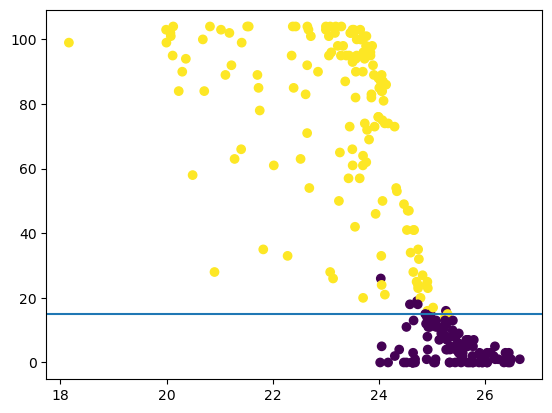

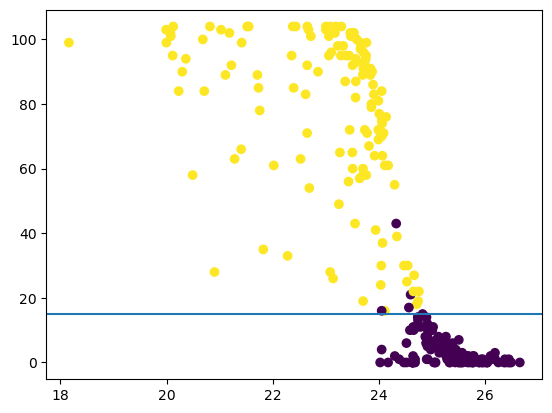

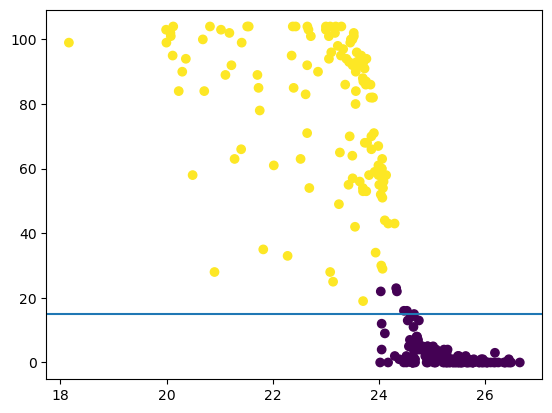

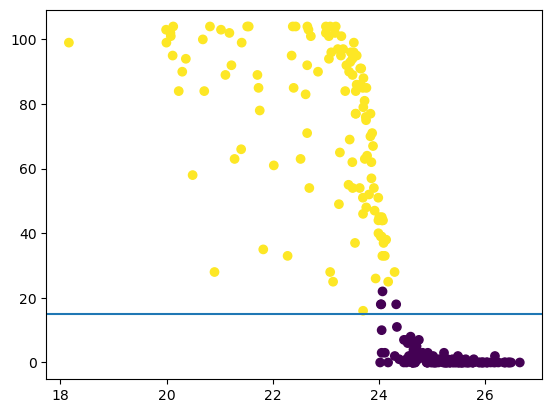

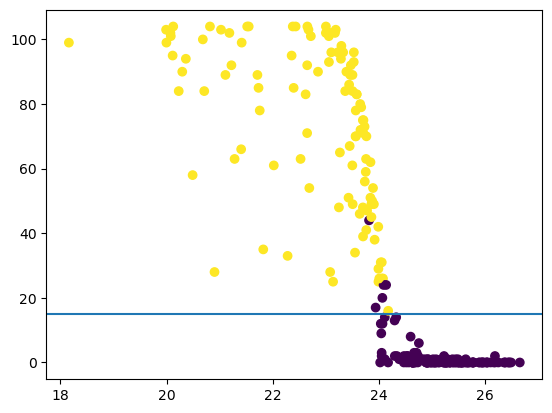

In [390]:
for snr in snrs:
    t = fit_data[snr]
    _t = t[t['in_search'] & (~t['filtered']) & ~((t['fake_detection'] < 15) & (t['mag'] < 24))]
    plt.scatter(_t['mag'], _t['points'], c=_t['found_points'])
    plt.axhline(15)
    plt.show()    

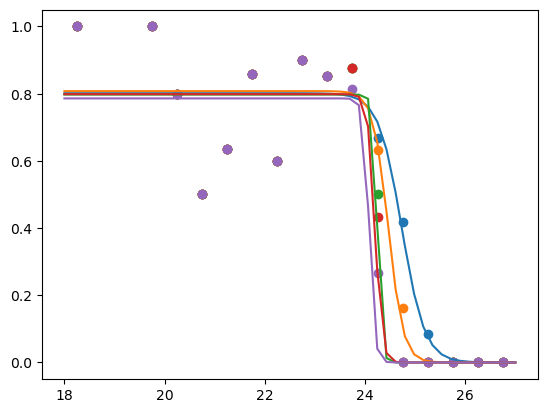

In [395]:
m_50 = []
for snr in snrs:
    t = fit_data[snr]
#     _t = t[t['in_search'] & (~t['filtered']) & ~((t['fake_detection'] < 15) & (t['mag'] < 24))]
    _t = t[t['in_search']]
    fit_result = do_fit(_t, found_col='found_points')
#     print(snr, )
    x, y, yerr = bin_detection(_t, 18, 27, found_col='found_points')
    plt.scatter(x, y)
    x = np.linspace(18, 27)
    y = p(x, fit_result['c'], fit_result['k'], fit_result['m_50'])
    plt.plot(x, y)
    m_50.append(fit_result['m_50'])

plt.show()

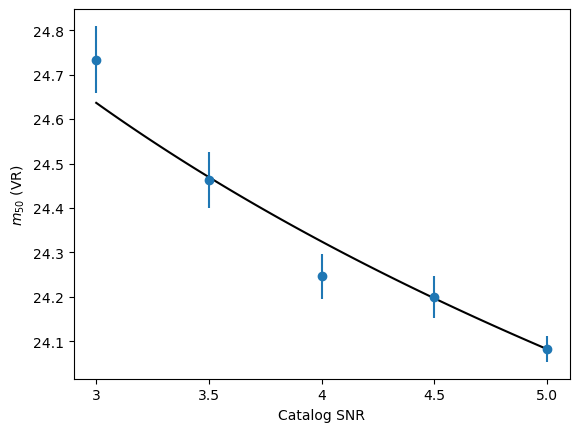

In [396]:
# I think this just isn't a very good way to measure the performance of the algorithm
# Because it changes based on what you include in the fit
# I also think we are seeing artifacts of the fit not an actual result...
# At SNR=3 we sample limiting magnitude of the exposure set
# At SNR=5 we don't, we just get a cutoff

x = np.linspace(min(snrs), max(snrs), 100)
y = -(5/2) * np.log10(x / max(snrs)) + m_50[snrs.index(5.0)]
plt.plot(x, y, color='k', label="expected")
plt.errorbar(snrs, m_50, yerr=sigma_m_50, fmt='o')
plt.xticks(snrs, ["3", "3.5", "4", "4.5", "5.0"])
plt.xlabel("Catalog SNR")
plt.ylabel("$m_{50}$ (VR)")
plt.show()

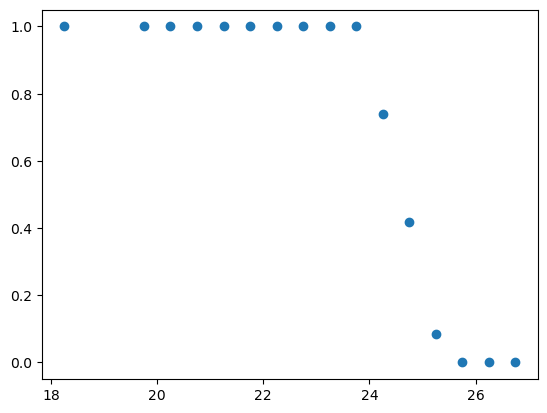

In [383]:
x, y, yerr = bin_detection(_t, 18, 27, found_col='found_points')
plt.scatter(x, y)

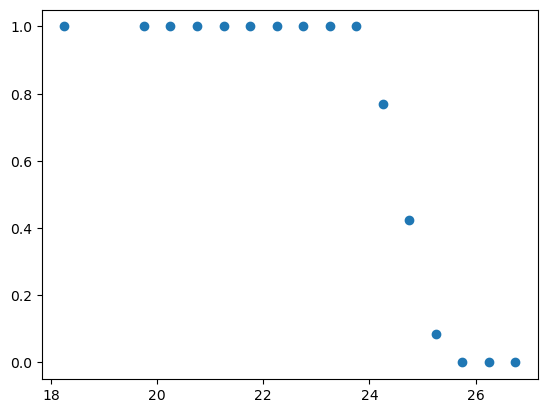

In [372]:
__t = _t[~((_t['fake_detection'] < 15) & (_t['mag'] < 24))]
x, y, yerr = bin_detection(__t, 18, 27, found_col='found_points')
plt.scatter(x, y)
plt.show()

In [359]:
_t[(~_t['found_points']) & (_t['fake_detection'] > 15)]

orbit,found_points,found_line,points,n_points,n_lines,fake_detection,fake_injection,filtered,in_search,detector,mag
int64,bool,bool,int64,int64,int64,int64,int64,bool,bool,int64,float64
10714893,False,False,19,0,0,19,84,False,True,8,24.721597550396176
10902401,False,False,26,0,0,26,60,False,True,37,24.037701167502515
11447771,False,False,16,0,0,16,104,False,True,35,25.26539258676702
13497327,False,False,18,0,0,18,85,False,True,53,24.735057023396998
14178134,False,False,18,0,0,18,92,False,True,59,24.58697871727407


In [325]:
_t[(~_t['found_points']) & (_t['fake_detection'] > 15)]

orbit,found_points,found_line,points,n_points,n_lines,fake_detection,fake_injection,filtered,in_search,detector,mag
int64,bool,bool,int64,int64,int64,int64,int64,bool,bool,int64,float64
10714893,False,False,19,0,0,19,84,False,True,8,24.721597550396176
10902401,False,False,26,0,0,26,60,False,True,37,24.037701167502515
11447771,False,False,16,0,0,16,104,False,True,35,25.26539258676702
13497327,False,False,18,0,0,18,85,False,True,53,24.735057023396998
14117798,False,False,34,0,0,34,104,False,True,8,24.600221019561516
14178134,False,False,18,0,0,18,92,False,True,59,24.58697871727407


In [326]:
print(list(map(lambda x : tuple(x), _t[(~_t['found_points']) & (_t['fake_detection'] > 15)][['orbit', 'detector']])))


[(10714893, 8), (10902401, 37), (11447771, 35), (13497327, 53), (14117798, 8), (14178134, 59)]


In [207]:
fit_result

{'c': 0.9999999982409832,
 'k': 2.0800201339510327,
 'm_50': 24.468739715715635,
 'sigma_c': 0.4884206925180764,
 'sigma_k': 1.6880546822299325,
 'sigma_m_50': 0.8500449594103247}

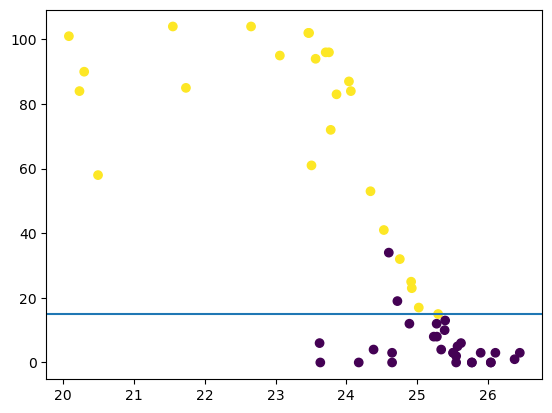

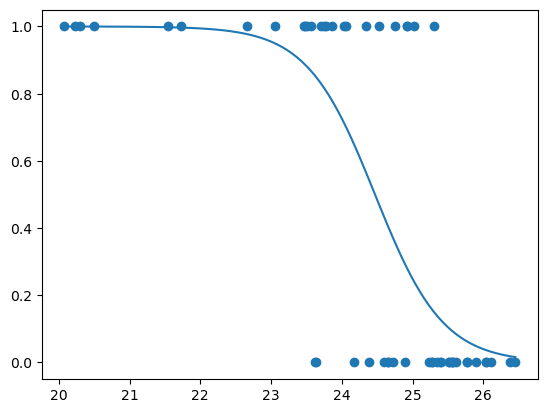

In [206]:
fit_result = do_fit(_t, found_col='found_points')

plt.scatter(_t['mag'], _t['points'], c=_t['found_points'])
plt.axhline(15)
plt.show()

x = np.linspace(_t['mag'].min(), _t['mag'].max(), 100)
y = p(x, fit_result['c'], fit_result['k'], fit_result['m_50'])
plt.scatter(_t['mag'], _t['found_points'])
plt.plot(x, y)
plt.show()

In [160]:
_t[(_t['mag'] < 25) & (_t['mag'] > 24) & (_t['fake_detection'] < 40) & (_t['fake_detection'] > 18)]

orbit,found_points,found_line,points,n_points,n_lines,fake_detection,fake_injection,in_search,detector,mag
int64,bool,bool,int64,int64,int64,int64,int64,bool,int64,float64
10714893,False,False,19,0,0,19,84,True,8,24.721597550396176
11926129,True,True,32,1,1,32,104,True,4,24.755975132108603
12408907,True,True,23,1,1,23,104,True,6,24.924930785137157
14117798,False,False,34,0,0,34,104,True,8,24.600221019561516
14155046,True,True,25,1,1,25,104,True,6,24.915834524269535


In [201]:
recoveries(
    search_prefix, 8, 3.0, "regular", "asteroid", step="clusters"
)[10714893]


{'points': {137: {'fake': 6, 'total': 47}},
 'line': {137: {'fake': 1, 'total': 84}},
 'catalog': {'fake': 19, 'total': 84},
 'info': {'vra': <Quantity -0.13515626 deg / d>,
  'vdec': <Quantity 0.04630394 deg / d>,
  'min_dv': <Quantity 0.00680113 deg / d>,
  'distance': <Quantity 0.00097648 deg>,
  'findable': True}}

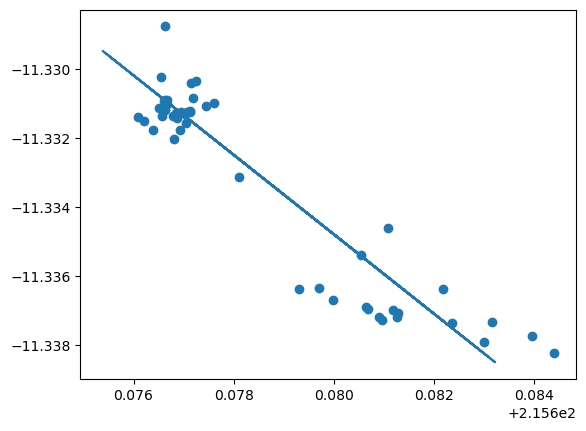

In [202]:
c = load_results(search_prefix, 8, 3.0, "regular", "asteroid", step="clusters")[137]
plt.scatter(c.points[:, 0], c.points[:, 1])
y = c.line.predict(c.points[:, 2] * u.day)
plt.plot(y[:, 0], y[:, 1])
plt.show()

In [200]:
recoveries(
    search_prefix, 8, 3.0, "regular", "asteroid", step="clusters"
)[14117798]

{'points': {9: {'fake': 5, 'total': 112},
  233: {'fake': 34, 'total': 59},
  677: {'fake': 2, 'total': 36}},
 'line': {},
 'catalog': {'fake': 34, 'total': 104},
 'info': {'vra': <Quantity -0.10665798 deg / d>,
  'vdec': <Quantity 0.04243794 deg / d>,
  'min_dv': <Quantity 0.00479569 deg / d>,
  'distance': <Quantity 0.00085545 deg>,
  'findable': True}}

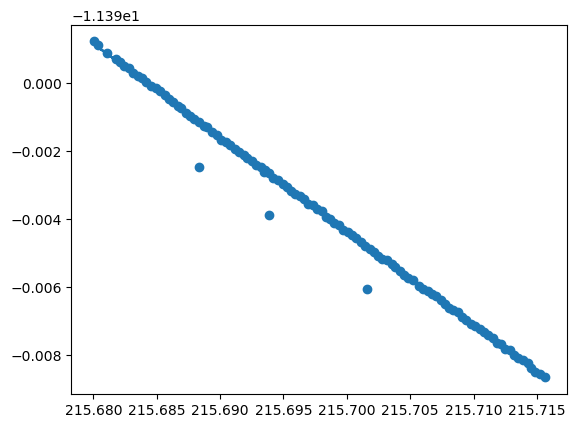

In [183]:
c = load_results(search_prefix, 8, 3.0, "regular", "asteroid", step="gathered_0")[9]
plt.scatter(c.points[:, 0], c.points[:, 1])
y = c.line.predict(c.points[:, 2] * u.day)
plt.plot(y[:, 0], y[:, 1])
plt.show()

In [351]:
from salad.serialize import write

In [353]:
write({233: c}, "233.pkl")



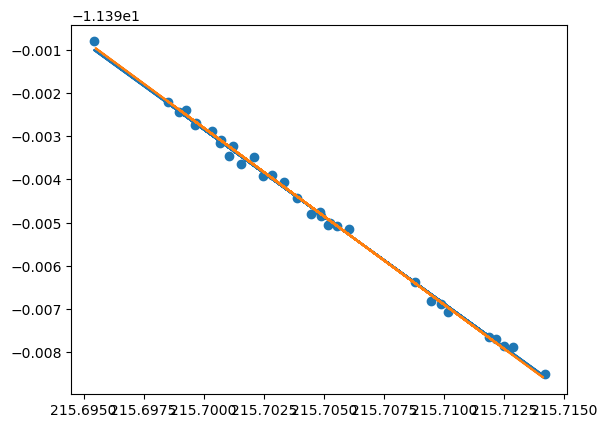

In [356]:
c = read("233_2.pkl")[233]
plt.scatter(c.points[:, 0], c.points[:, 1])
y = c.line.predict(c.points[:, 2] * u.day)
plt.plot(y[:, 0], y[:, 1])

line = refine(c)['line']
y = line.predict(c.points[:, 2] * u.day)
plt.plot(y[:, 0], y[:, 1])
plt.show()

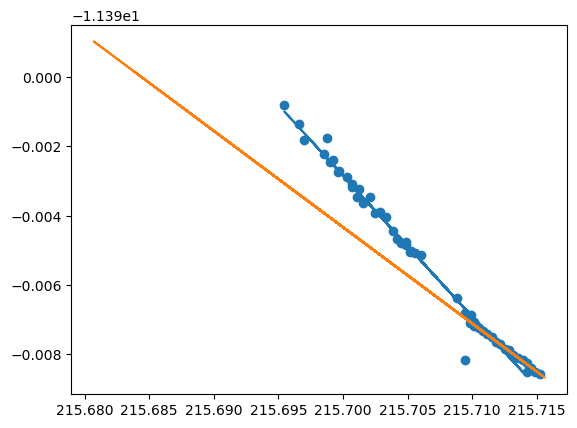

In [350]:
c = load_results(search_prefix, 8, 3.0, "regular", "asteroid", step="gathered_0")[233]
plt.scatter(c.points[:, 0], c.points[:, 1])
y = c.line.predict(c.points[:, 2] * u.day)
plt.plot(y[:, 0], y[:, 1])

line = refine(c)['line']
y = line.predict(c.points[:, 2] * u.day)
plt.plot(y[:, 0], y[:, 1])
plt.show()

In [187]:
from salad.refine import refine

In [168]:
import astropy.coordinates

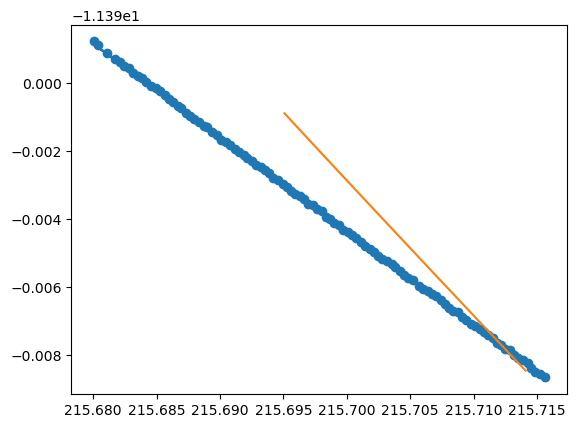

In [346]:
c = load_results(search_prefix, 8, 3.0, "regular", "asteroid")[9]
plt.scatter(c.points[:, 0], c.points[:, 1])
y = c.line.predict(c.points[:, 2] * u.day)
plt.plot(y[:, 0], y[:, 1])

f = fakes[fakes['ORBITID'] == 14117798]

sc = astropy.coordinates.SkyCoord(f['RA']*u.deg, f['DEC']*u.deg)
plt.plot(sc.ra, sc.dec)
plt.show()

In [147]:
t[(t['mag'] < 21) & ((t['fake_detection'] / t['fake_injection']) < 0.2)]

orbit,found_points,found_line,points,n_points,n_lines,fake_detection,fake_injection,in_search,detector,mag
int64,bool,bool,int64,int64,int64,int64,int64,bool,int64,float64
10464147,False,False,0,0,0,0,7,True,6,20.49118589689963


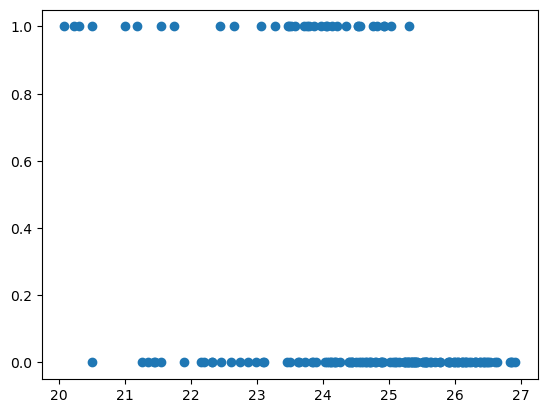

In [150]:
plt.scatter(t['mag'], t['found_points'])

In [238]:
search_prefix = "new"
detector = 1

f = []
for detector in range(1, 63):
    if detector in [2, 61]:
        continue
    try:
        fakes = read(f"/epyc/projects/salad/search/{search_prefix}/DEEP/20190403/A0c/detector_{detector}/fakes.pkl")
    except:
        print(detector)
    f.append(fakes)
fakes = astropy.table.vstack(f)


mags = []
for g in fakes.group_by("ORBITID").groups:
    mags.append(
        {
            "orbit": g[0]['ORBITID'],
            "mag": np.median(g['MAG'])
        }
    )
mags = astropy.table.Table(mags)

3.0 35


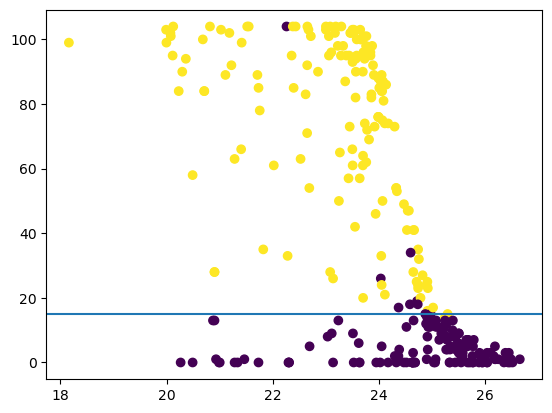

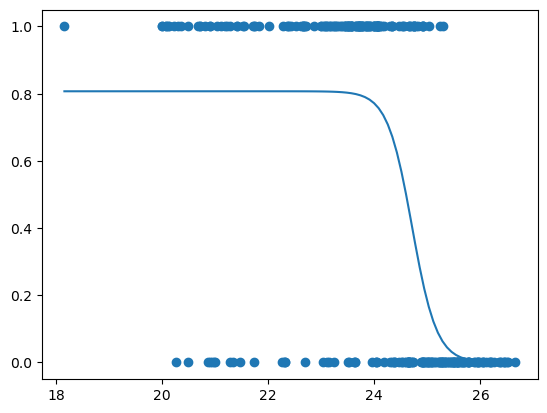

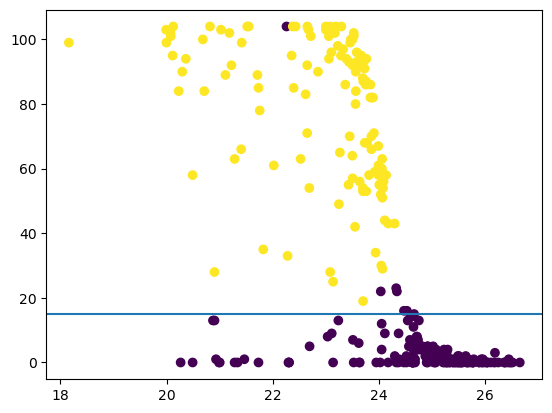

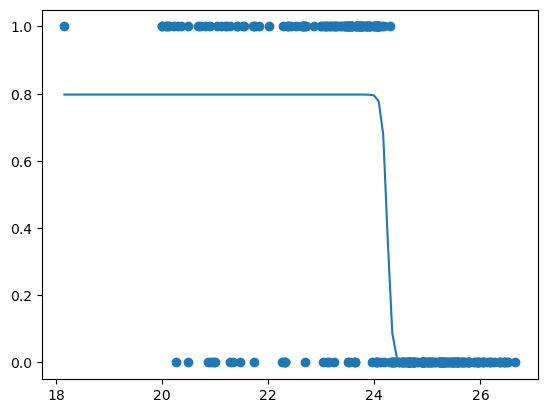

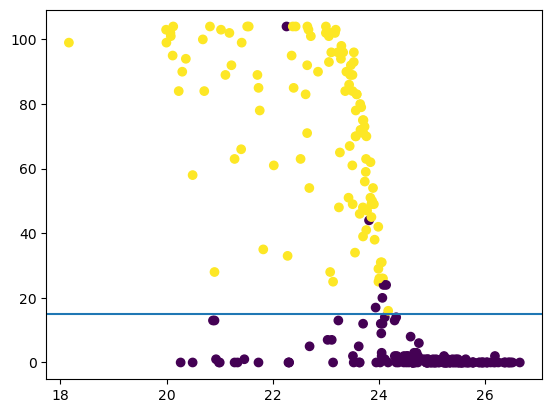

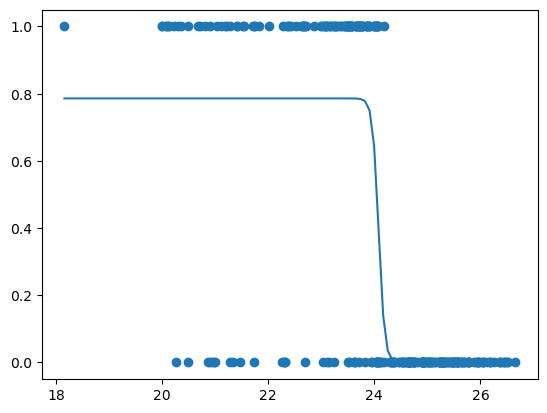

In [245]:
for snr in [3.0, 4.0, 5.0]:
    fo = []
    fi = []
    for detector in range(1, 63):
        if detector in [2, 61]:
            continue
        try:
            r = recoveries("new", detector, snr, "regular", "asteroid")
        except:
            print(snr, detector)
        found = was_found(r)
        found['detector'] = detector
    #     findable = []
    #     for k in r:
    #         if 'findable' in r[k]['info']:
    #             findable.append(
    #                 {
    #                     "orbit": k,
    #                     "in_search": r[k]['info']['findable'],
    #                     "detector": detector
    #                 }
    #             )
    #         else:
    #             print(k)
    #     findable = astropy.table.Table(findable)

        fo.append(found)
    #     fi.append(findable)

    found = astropy.table.vstack(fo)
    # findable = astropy.table.vstack(fi)
    #     _t.append()

    # how do I distinguish t['points'] = 0 meaning not detected vs not included because of masks?

    t = astropy.table.join(found, mags, keys=['orbit'])
    _t = t[t['in_search'] & (t['fake_injection'] > 0)]

    fit_result = do_fit(_t, found_col='found_points')

    plt.scatter(_t['mag'], _t['points'], c=_t['found_points'])
    plt.axhline(15)
    plt.show()

    x = np.linspace(_t['mag'].min(), _t['mag'].max(), 100)
    y = p(x, fit_result['c'], fit_result['k'], fit_result['m_50'])
    plt.scatter(_t['mag'], _t['found_points'])
    plt.plot(x, y)
    plt.show()

In [71]:
found[found['orbit'] == 10464147]

orbit,found_points,found_line,points,findable,detector
int64,bool,bool,int64,bool,int64
10464147,True,False,58,True,3
10464147,False,False,0,True,6


In [56]:
recoveries(search_prefix, 3, 3.0, "regular", "asteroid")

{5347168: {'points': {},
  'line': {},
  'catalog': {'fake': 67, 'total': 104},
  'info': {'vra': <Quantity -0.00176522 deg / d>,
   'vdec': <Quantity 0.00062701 deg / d>,
   'min_dv': <Quantity 0.09822037 deg / d>,
   'distance': <Quantity 0.01752049 deg>,
   'findable': False}},
 13596119: {'points': {},
  'line': {},
  'catalog': {'fake': 0, 'total': 47},
  'info': {'vra': <Quantity -0.1208977 deg / d>,
   'vdec': <Quantity 0.11677342 deg / d>,
   'min_dv': <Quantity 0.00813896 deg / d>,
   'distance': <Quantity 0.00064964 deg>,
   'findable': True}},
 683271: {'points': {},
  'line': {},
  'catalog': {'fake': 0, 'total': 104},
  'info': {'vra': <Quantity -0.01673448 deg / d>,
   'vdec': <Quantity 0.0073607 deg / d>,
   'min_dv': <Quantity 0.08234226 deg / d>,
   'distance': <Quantity 0.01468816 deg>,
   'findable': False}},
 11697512: {'points': {},
  'line': {},
  'catalog': {'fake': 0, 'total': 7},
  'info': {'vra': <Quantity -0.3197902 deg / d>,
   'vdec': <Quantity -0.19267642 

In [86]:
was_found(
    recoveries(
        search_prefix, 1, 3.0, "regular", "asteroid"
    )
)

orbit,found_points,found_line,points,findable
int64,bool,bool,int64,bool
13039521,False,False,1,True
5182786,False,False,1,False
10564514,False,False,0,True
2732908,False,False,0,False
14621325,True,True,85,True
10053463,False,False,3,True
6009903,False,False,0,False
13776855,True,True,72,True
4279478,False,False,11,False


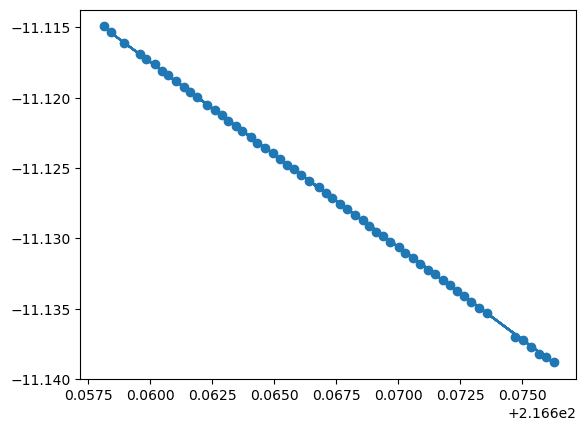

In [69]:
import astropy.units as u
c = load_results(search_prefix, 3, 3.0, "regular", "asteroid")[18]
plt.scatter(c.points[:, 0], c.points[:, 1])
y = c.line.predict(c.points[:, 2] * u.day)
plt.plot(y[:, 0], y[:, 1])

In [30]:
found

orbit,found,points,findable,detector
int64,bool,int64,bool,int64
13039521,False,1,True,1
5182786,False,1,False,1
10564514,False,0,True,1
2732908,False,0,False,1
14621325,True,85,True,1
10053463,False,3,True,1
6009903,False,0,False,1
13776855,True,72,True,1
4279478,False,11,False,1


In [24]:
findable.group_by("orbit").groups[92]

orbit,in_search,detector
int64,bool,int64
10328446,True,8
10328446,True,9


In [31]:
found.group_by("orbit").groups[132]

orbit,found,points,findable,detector
int64,bool,int64,bool,int64
13232368,False,0,True,3
13232368,False,0,True,7


In [21]:
for i, g in enumerate(found.group_by("orbit").groups):
    print(i, len(g))

0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 1
11 1
12 1
13 1
14 1
15 1
16 1
17 1
18 1
19 1
20 1
21 1
22 1
23 1
24 1
25 1
26 1
27 1
28 1
29 1
30 1
31 1
32 1
33 1
34 1
35 1
36 1
37 1
38 1
39 1
40 1
41 1
42 1
43 1
44 1
45 1
46 1
47 1
48 1
49 1
50 1
51 1
52 1
53 1
54 1
55 1
56 1
57 1
58 1
59 1
60 1
61 1
62 1
63 1
64 1
65 1
66 1
67 1
68 1
69 1
70 1
71 1
72 1
73 1
74 1
75 1
76 1
77 1
78 1
79 1
80 1
81 1
82 1
83 1
84 1
85 1
86 1
87 1
88 1
89 1
90 1
91 1
92 1
93 2
94 1
95 2
96 2
97 1
98 1
99 1
100 1
101 1
102 1
103 1
104 1
105 1
106 1
107 1
108 1
109 1
110 1
111 1
112 1
113 1
114 1
115 1
116 1
117 1
118 1
119 1
120 1
121 1
122 2
123 1
124 1
125 1
126 1
127 1
128 1
129 1
130 1
131 1
132 2
133 1
134 1
135 1
136 1
137 1
138 1
139 1
140 1
141 1
142 1
143 1
144 1
145 1
146 1
147 1
148 1
149 1
150 1
151 1
152 1
153 1


In [16]:
for i, g in enumerate(findable.group_by("orbit").groups):
    print(i, len(g))

0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 1
11 1
12 1
13 1
14 1
15 1
16 1
17 1
18 1
19 1
20 1
21 1
22 1
23 1
24 1
25 1
26 1
27 1
28 1
29 1
30 1
31 1
32 1
33 1
34 1
35 1
36 1
37 1
38 1
39 1
40 1
41 1
42 1
43 1
44 1
45 1
46 1
47 1
48 1
49 1
50 1
51 1
52 1
53 1
54 1
55 1
56 1
57 1
58 1
59 1
60 1
61 1
62 1
63 1
64 1
65 1
66 1
67 1
68 1
69 1
70 1
71 1
72 1
73 1
74 1
75 1
76 1
77 1
78 1
79 1
80 1
81 1
82 1
83 1
84 1
85 1
86 1
87 1
88 1
89 1
90 1
91 1
92 2
93 1
94 2
95 2
96 1
97 1
98 1
99 1
100 1
101 1
102 1
103 1
104 1
105 1
106 1
107 1
108 1
109 1
110 1
111 1
112 1
113 1
114 1
115 1
116 1
117 1
118 1
119 1
120 1
121 2
122 1
123 1
124 1
125 1
126 1
127 1
128 1
129 1
130 1
131 2
132 1
133 1
134 1
135 1
136 1
137 1
138 1
139 1
140 1
141 1
142 1
143 1
144 1
145 1
146 1
147 1
148 1
149 1
150 1
151 1
152 1


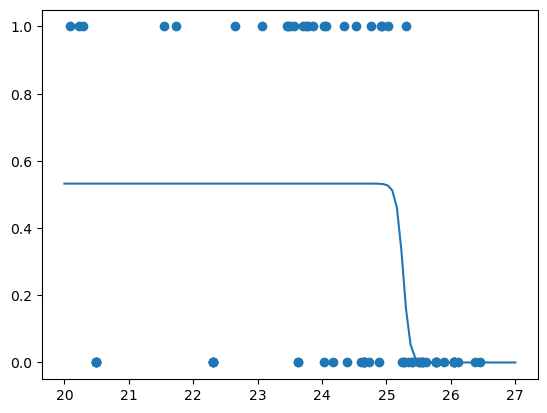

In [34]:
t = astropy.table.join(astropy.table.join(found, findable, keys=['orbit']), mags, keys=['orbit'])
_t = t[t['in_search']]
fit = do_fit(_t)
plt.scatter(_t['mag'], _t['found'])
plt.plot(
    np.linspace(20, 27, 100), 
    p(np.linspace(20, 27, 100), fit['c'], fit['k'], fit['m_50'])
)
plt.show()

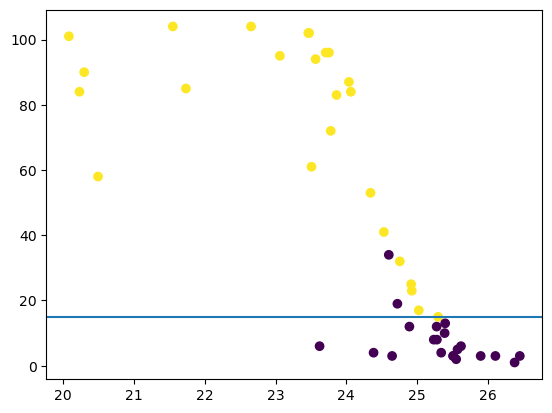

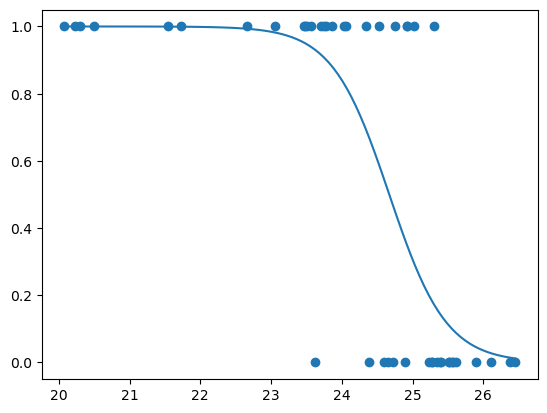

In [45]:
t

orbit,found,points,findable,detector,mag
int64,bool,int64,bool,int64,float64
2099,False,2,False,4,26.600090279060534
125150,False,101,False,8,21.43204477748916
155315,False,29,False,7,24.396334093520572
188646,False,60,False,4,24.12278263090937
222968,False,104,False,9,22.60888557106631
683271,False,0,False,3,26.847341789648272
719698,False,6,False,5,25.28050085364884
856035,False,20,False,9,25.144378778667033
894980,False,3,False,9,24.700095224077486


In [46]:
_t[(_t['mag'] < 21 ) & (_t['points'] < 60)]

orbit,found,points,findable,detector,mag
int64,bool,int64,bool,int64,float64
10464147,False,58,True,3,20.49118589689963


In [144]:
found[found['orbit'] == 10464147]

orbit,found,points
int64,bool,int64
10464147,False,58
10464147,False,0


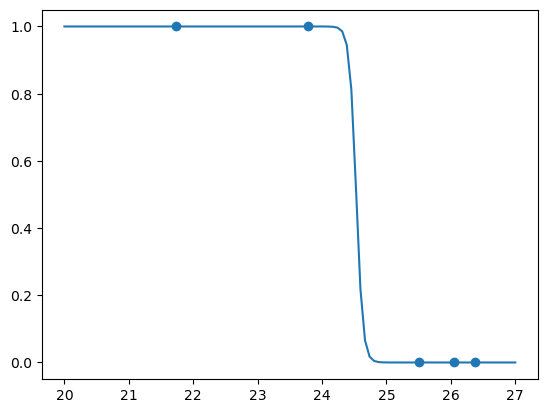

In [100]:
r = recoveries("new", 1, 3.0, "regular", "asteroid")
found = was_found(r)
findable = []
for k in r:
    findable.append(
        {
            "orbit": k,
            "in_search": r[k]['info']['findable']
        }
    )
findable = astropy.table.Table(findable)

t = astropy.table.join(astropy.table.join(found, findable), mags)

# how do I distinguish t['points'] = 0 meaning not detected vs not included because of masks?
_t = t[t['in_search']]
fit = do_fit(_t)
plt.scatter(_t['mag'], _t['found'])
plt.plot(
    np.linspace(20, 27, 100), 
    p(np.linspace(20, 27, 100), fit['c'], fit['k'], fit['m_50'])
)
plt.show()

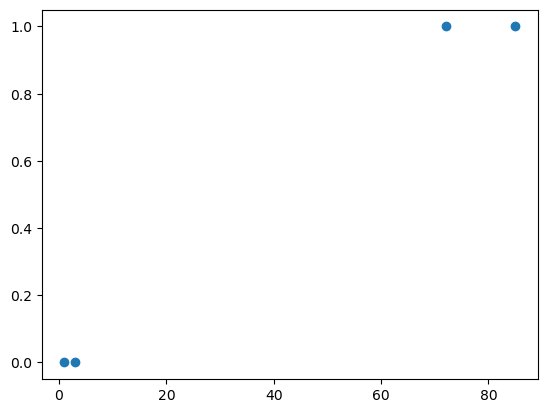

In [90]:
plt.scatter(_t['points'], _t['found'])
plt.show()

In [43]:
for k in findable:
    if findable[k]:
        print(r[k]['catalog'])

{'fake': 1, 'total': 104}
{'fake': 0, 'total': 104}
{'fake': 0, 'total': 104}
{'fake': 11, 'total': 104}
{'fake': 0, 'total': 104}
{'fake': 1, 'total': 104}
{'fake': 19, 'total': 104}
{'fake': 20, 'total': 104}
{'fake': 0, 'total': 104}


In [ ]:
# as a function of the number of times it appeared in the catalog
# as a function of magnitude of the object...
